# Text Mining Coursework 2
## Topic: WinterOlympics
### 3 Questions: 
1) What is the dominant sentiment towards the Winter Olympics?

2) What were poeple mostly talking about for the Winter Olympics?

3) Which country has been mostly talked about during Winter Olympics? What are the people's opinion of that country?

## Libraries Used

In [3]:
import pandas as pd
import tweepy
import requests
import gensim
import gensim.corpora as corpora
import re
import emoji
import nltk
import os
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import warnings
import en_core_web_md
import spacy # need have spacy version >=3.2.3
import en_core_web_trf
import numpy as np
import matplotlib.pyplot as plt
from spacy_entity_linker import EntityLinker
from spacy.language import Language
from access_token import tokens
from wordcloud import WordCloud
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from pprint import pprint
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

# ignore warnings for now
warnings.filterwarnings("ignore")

# may need to download a few packages
# !pip install spacy
# !pip install tweepy
# !pip install wordcloud
# !pip install gensim
# !pip install pyldavis
# !pip install vaderSentiment
# !pip install spacy-transformers
# !pip install spacy-entity-linker
# !python -m spacy download en_core_web_trf  ### 460 MB
# !python -m spacy download en_core_web_md   ### 30 MB
# !python -m spacy_entity_linker download "knowledge_base"
# !pip install spacy-entity-linker

# Configuring Twitter API

In [4]:
# auth = tweepy.OAuthHandler(tokens['api_token'], tokens['api_token_secret'])
# auth.set_access_token(tokens['access_token'], tokens['access_token_secret'])

auth = tweepy.OAuth1UserHandler(tokens['api_token'], tokens['api_token_secret'], tokens['access_token'], tokens['access_token_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True)

# Download dataset

We use a command $snscrape 'twitter-search "#WinterOlympics since:2022-02-04 until:2021-02-20 lang:en" > scraped_tweets.txt'$ to download the dataset.
Dates "2022-02-04" and "2021-02-20" are the start and end date of winter Olympics in Beijing 2022 respectively. The command gives all tag-related tweets in a form of urls, so we need to process them followed by converting to a pandas DataFrame.

In [6]:
tweet_urls = pd.read_csv("scraped_tweets.txt", index_col= None, header = None, names = ["tweet_urls"])
# print(tweet_urls)

## Convert urls to tweets

In [7]:
# Extract the tweet id
tweet_ids = lambda x: x["tweet_urls"].split("/")[-1]
# Store tweet id in another column
tweet_urls['tweet_ids'] = tweet_urls.apply(tweet_ids, axis=1)
ids = tweet_urls['tweet_ids'].tolist()

def url2tweet(IDs): # a list of ids, max 100
    all_status = api.lookup_statuses(IDs)
    tweets_list = [[status.created_at, status.user.name, status.user.location, status.text] for status in all_status]
    return tweets_list


def get_all_tweets(IDs): # a list of ids
    num_sections = (len(IDs) - 1) // 100 + 1
    first_section = ids[:100]
    data = url2tweet(first_section)
    for i in tqdm(range(1, num_sections)):
        current_ids = ids[i*100:(i+1)*100]
        current_tweet_list = url2tweet(current_ids)
        data = np.concatenate([data, current_tweet_list])
    return data

data = get_all_tweets(ids)

100%|█████████████████████████████████████████| 523/523 [06:10<00:00,  1.41it/s]


In [8]:
tweets_df = pd.DataFrame(data=data, columns=['date', 'user', 'location', 'text'])
tweets_df.to_csv("data.csv", quotechar='"', encoding='utf8', index = False, header=True)
tweets_df.head(len(tweets_df))

,date,user,location,text
0,2022-02-19 23:45:01+00:00,NEWS CENTER Maine,"Maine, USA",Tonight at 7:30: Our final Olympic Zone show o...
1,2022-02-19 23:47:19+00:00,Nicoya,Lincolnshire,"#WinterOlympics Up early for #menscurling , af..."
2,2022-02-19 23:12:02+00:00,Sweepers Curling 🥌,Edinburgh,@Team_Muirhead @richardosman Honestly! 2 hours...
3,2022-02-19 23:55:43+00:00,Georgie Heath,"London, England",To sleep and set curling alarm or just stay up...
4,2022-02-19 23:04:20+00:00,Sports update.,World,#WinterOlympics: Sweden beat Switzerland to wi...
...,...,...,...,...
52278,2022-02-04 00:00:13+00:00,NBC Connecticut,Connecticut,Cecily from Wallingford is ready to cheer on @...
52279,2022-02-04 00:04:17+00:00,UofSC College of HRSM,"Columbia, South Carolina",Sport and Entertainment Management Professor M...
52280,2022-02-04 00:00:02+00:00,Global Times,"Beijing, China",#GTGraphic: Welcome to China! When the #Beijin...
52281,2022-02-04 00:28:52+00:00,BetRivers,AZ/CO/IA/IL/IN/LA/MI/NY/PA/VA,🥌 TONIGHT 🥌\n\nanyone have some mixed curling ...


# Data Cleaning

In [9]:
def remove_emoji(string):
    string = emoji.get_emoji_regexp().sub(u'', string)
    return string

# emojis = '(｀ヘ´) 🤗⭕🤓🤔🤘🦁⭐🆗🆖🈲🤐🤗🤖🤑🆙⏩🥌🍒💚🏅'
# print(remove_emoji(emojis))

In [10]:
def data_cleaning(data):
    # Remove hyperlinks
    data.text = data.text.map(lambda x: re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', x))

    # Remove punctuation
    data.text = data.text.map(lambda x: re.sub('[,\\!?…]', ' ', x))

    # Remove unnecessary line breaks
    data.text = data.text.map(lambda x: re.sub(r"\n", '', x))

    # Convert the titles to lowercase
    data.text = data.text.map(lambda x: x.lower())

    # Remove emojis
    data.text = data.text.map(lambda x: remove_emoji(x))

In [11]:
# Uncomment the line below if loading from previously saved CSV
tweets_df = pd.read_csv('data.csv', quotechar='"', encoding='utf8')

data_cleaning(tweets_df)

# store the processed tweets to csv
tweets_df.to_csv ('data_cleaned.csv', quotechar='"', encoding='utf8', index = False, header=True)

# Task 2: What were poeple mostly talking about for the Winter Olympics?

## Exploration using a word cloud

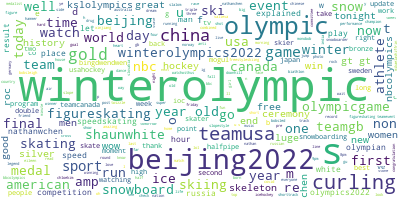

In [12]:
tweets_df = pd.read_csv('data_cleaned.csv', quotechar='"', encoding='utf8')

# get all tweets without duplication
unique_tweets = list(set(list(tweets_df['text'].values)))
unique_tweets = [t for t in unique_tweets if t]

# join the words of the different tweets together into one string
long_string = ' '.join(unique_tweets)
new_long_string = ' '.join(set(long_string.split(" ")))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(new_long_string)

# visualize the word cloud
wordcloud.to_image()

## Topic Modelling

### Configuring Stopwords

In [13]:
# get stopwords from nltk library, without outputing the download information to terminal
nltk.download('stopwords', quiet=True)

stop_words = stopwords.words('english')

# add more stopwords
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'winterolympic', 'olympic', 'winterolympics',
                   'olympics', 'beijing','winterparalympic', 'beijing2022', 'winter', 'today', 'like', 
                   'would', 'watch', 'tonight', 'first', 'time', 'go', 'next', 'events', 'let', 
                   'love', 'year', 'watching', 'day', 'run', 'big', 'live', 'know', 'well','going', 'great'
                   , 'get', 'one', 'good', 'th', 'white', 'back','game', 'amp', 'end', 'see', 'watchwithus'
                   , 'much'])

# print(stop_words)
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# get the tweets in a list
data = tweets_df.text.values.tolist()

data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)
# print(data_words)

## Get the Mostly Talked Topics

In [14]:
# create a dictionary
id2word = corpora.Dictionary(data_words)

# create a corpus
texts = data_words

# convert the corpus into a BoW representation
corpus = [id2word.doc2bow(text) for text in texts]

# set number of topics
num_topics = 5

# build an LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# print keywords in each topic
pprint(lda_model.print_topics())

[(0,
  '0.019*"gold" + 0.014*"curling" + 0.013*"medal" + 0.010*"team" + '
  '0.010*"teamusa" + 0.007*"figureskating" + 0.007*"men" + 0.007*"women" + '
  '0.007*"ice" + 0.006*"figure"'),
 (1,
  '0.014*"women" + 0.014*"teamusa" + 0.010*"usa" + 0.010*"curling" + '
  '0.008*"team" + 0.008*"gold" + 0.008*"canada" + 0.006*"nbc" + 0.006*"china" '
  '+ 0.006*"win"'),
 (2,
  '0.013*"skating" + 0.013*"gold" + 0.012*"team" + 0.008*"medal" + '
  '0.007*"women" + 0.006*"opening" + 0.006*"ceremony" + 0.006*"figure" + '
  '0.005*"speed" + 0.005*"new"'),
 (3,
  '0.025*"curling" + 0.008*"snowboard" + 0.007*"athletes" + 0.006*"team" + '
  '0.006*"teamusa" + 0.005*"games" + 0.005*"men" + 0.005*"china" + 0.005*"ice" '
  '+ 0.005*"usa"'),
 (4,
  '0.008*"china" + 0.007*"teamusa" + 0.007*"figure" + 0.007*"curling" + '
  '0.006*"skating" + 0.005*"us" + 0.005*"nathan" + 0.005*"openingceremony" + '
  '0.005*"gold" + 0.005*"skiing"')]


### Visualise the topics

In [15]:
doc_lda = lda_model[corpus]

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./'+str(num_topics))

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# uncomment this if you want to save LDAvis_prepared file
# with open(LDAvis_data_filepath, 'wb') as f:
#     pickle.dump(LDAvis_prepared, f)
# f.close()

# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)
# f.close()

pyLDAvis.save_html(LDAvis_prepared, './saved_topics.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.017391  0.020244       1        1  22.418595
1     -0.027607  0.044557       2        1  20.831111
2     -0.060805 -0.001651       3        1  20.530466
4      0.014359 -0.094134       4        1  18.928379
3      0.091443  0.030985       5        1  17.291450, topic_info=              Term         Freq        Total Category  logprob  loglift
26         curling  4454.000000  4454.000000  Default  30.0000  30.0000
55            gold  3751.000000  3751.000000  Default  29.0000  29.0000
48         skating  2223.000000  2223.000000  Default  28.0000  28.0000
790         canada   900.000000   900.000000  Default  27.0000  27.0000
36           women  2626.000000  2626.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
490        chinese   162.561597   647.887845   Topic5  -6.0015   0.3723
86          skiing   184.857507  1124.741565   Topic5  -5.8730  -0.0508
257  figureskating   181.255171  1622.081628   Topic5  -5.8927  -0.4366
327           look   155.256266   556.920234   Topic5  -6.0475   0.4776
419           last   156.428631   732.731253   Topic5  -6.0400   0.2108

[461 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
12034      4  0.866677  actively
1390       1  0.945505       afp
1390       2  0.052528       afp
8685       1  0.103873    africa
8685       3  0.882920    africa
...      ...       ...       ...
1977       1  0.923605       zhi
815        1  0.090305       zoi
815        2  0.821780       zoi
815        4  0.063214       zoi
815        5  0.027092       zoi

[1129 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 5, 4])

# Hence, from the visualisation above we can conclude, people were mostly talking about these topics for the Winter Olympics:
$ Gold medal $, $curling$, $skating$, $china$, $woman$ and $team USA$

# Task 1: What is the dominant sentiment towards the Winter Olympics?

# Sentiment Analysis

In [16]:
all_pos = []
all_neg = []
dates = np.arange(4, 20)
for date in dates:
    neu = []
    pos = []
    neg = []
    
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    tweets_df_copy = tweets_df.loc[tweets_df['date'].str.contains(cur_date)]
    
    # Removing duplicate tweets
    unique_tweets = list(set(list(tweets_df_copy['text'].values)))
    unique_tweets = [t for t in unique_tweets if t]
    
    analyzer = SentimentIntensityAnalyzer()
    for tweet_text in unique_tweets:
        vs = analyzer.polarity_scores(tweet_text)
        pos.append(vs['pos'])
        neg.append(vs['neg'])
    
    all_pos.append(pos)
    all_neg.append(neg)

## Get rates of positive/negative

In [17]:
rates = []
for i in range(len(all_pos)):
    cur_pos = [x for x in all_pos[i] if x > 0.3]
    cur_neg = [x for x in all_neg[i] if x > 0.3]
    rates.append(len(cur_pos)/len(cur_neg))

## Visualise the rates

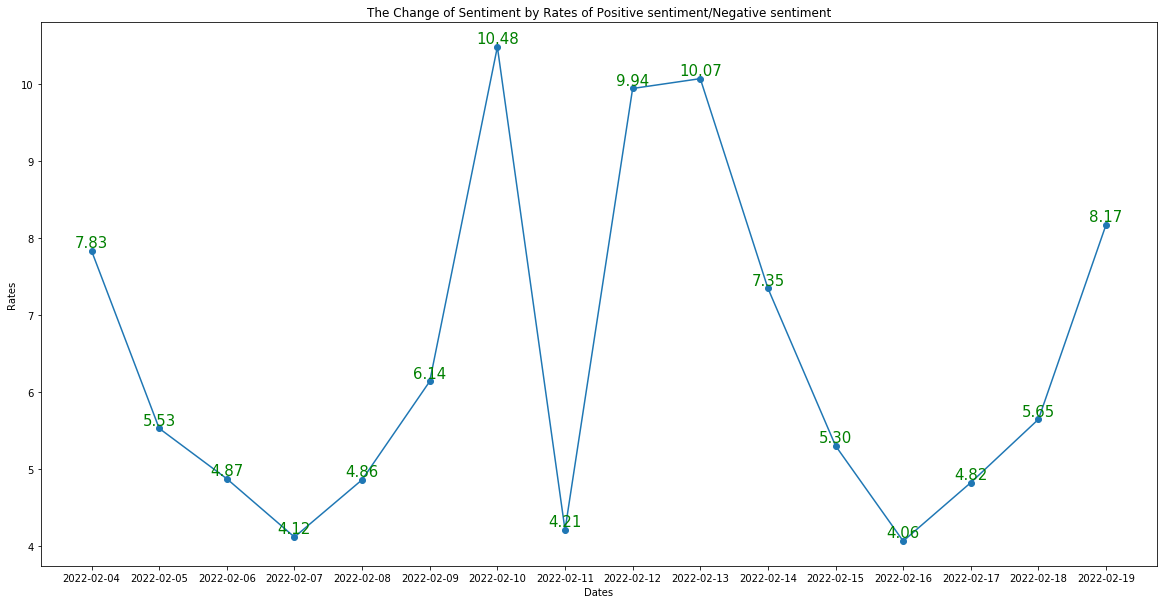

In [18]:
labels = []
for date in dates:
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    labels.append(cur_date)
    
plt.figure(figsize=(20,10))
plt.plot(rates, 'o-')
plt.xticks(range(len(labels)), labels)
plt.xlabel('Dates')
plt.ylabel('Rates')
plt.title("The Change of Sentiment by Rates of Positive sentiment/Negative sentiment")
x = dates
y = np.array(rates)
for _x, _y in zip(x, y):
    plt.text(_x-4, _y+0.01, '%.2f'%_y, ha='center', va='bottom', size=15, c='green')
plt.show()

# Task 3: Which country has been mostly talked about during Winter Olympics? What are the people's opinion of that country?

# Named Entity Recognition

In [22]:
nlp = spacy.load('en_core_web_trf') # Transformer based pre-trained model 438 MB

In [23]:
# athletes = []
countries = {}
stop_words = ['beijing2022', 'beijing']

for tweet_text in unique_tweets:
    doc = nlp(tweet_text)
#     print(tweet_text)
    for ne in doc.ents:
#         if ne.label_ == 'GPE' or ne.label_ == 'LOC':
#         print(ne.label_)
        if ne.label_ == 'GPE':
            tweet = tweet_text[ne.start_char:ne.end_char]
            if tweet not in stop_words and tweet not in countries.keys():
                countries[tweet] = 1
            elif tweet not in stop_words:
                countries[tweet] += 1

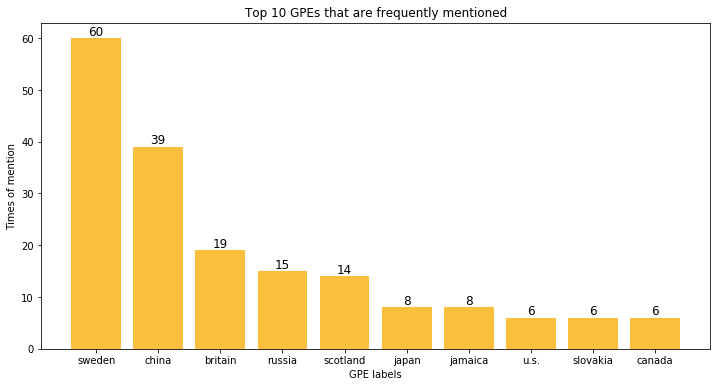

In [39]:
countries = {k: v for k, v in sorted(countries.items(), key=lambda item: item[1], reverse=True)}
names = list(countries.keys())[0:10]
values = list(countries.values())[0:10]
plt.figure(figsize=(12,6))
plt.ylabel('Times of mention')
plt.xlabel('GPE labels')
plt.title('Top 10 GPEs that are frequently mentioned')
plt.bar(range(10), values, tick_label=names, color = '#fac03d')
for _x, _y in zip(np.arange(10), values):
    plt.text(_x, _y, _y, ha='center', va='bottom', size=12, c='black')
plt.show()

In [26]:
mostly_talked_country = list(countries.keys())[0]
print("As the bar chart shows, the mostly talked country is", mostly_talked_country)

As the bar chart shows, the mostly talked country is sweden


In [40]:
all_pos = []
all_neg = []
dates = np.arange(4, 20)
for date in dates:
    neu = []
    pos = []
    neg = []
    
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
#     print(cur_date)
    tweets_df_copy = tweets_df.loc[tweets_df['date'].str.contains(cur_date)]
    tweets_df_copy = tweets_df_copy.loc[tweets_df_copy['text'].str.contains(mostly_talked_country)]
#     print(tweets_df_copy)
    # Removing duplicate tweets
    unique_tweets = list(set(list(tweets_df_copy['text'].values)))
    unique_tweets = [t for t in unique_tweets if t]
    
    analyzer = SentimentIntensityAnalyzer()
    for tweet_text in unique_tweets:
        vs = analyzer.polarity_scores(tweet_text)
        pos.append(vs['pos'])
        neg.append(vs['neg'])
    
    all_pos.append(pos)
    all_neg.append(neg)
    
#     break

In [41]:
print(all_pos)
print(all_neg)

[[0.365, 0.175, 0.309, 0.0, 0.0, 0.0, 0.107, 0.135, 0.314, 0.0, 0.275, 0.0, 0.0, 0.0, 0.0, 0.0, 0.198, 0.0, 0.139], [0.0, 0.0, 0.0, 0.161, 0.0, 0.291, 0.0, 0.0, 0.0, 0.49, 0.405, 0.306], [0.0, 0.192, 0.143, 0.297, 0.156, 0.177, 0.444, 0.156, 0.133, 0.0, 0.101, 0.0, 0.261, 0.24, 0.134, 0.0, 0.0, 0.338], [0.0, 0.181, 0.184, 0.0, 0.0, 0.0, 0.195, 0.0, 0.317, 0.15, 0.262, 0.102, 0.0, 0.252, 0.0], [0.0, 0.265, 0.31, 0.133, 0.259, 0.0, 0.0, 0.0, 0.222, 0.29, 0.0, 0.144, 0.344, 0.0, 0.357, 0.0, 0.292], [0.171, 0.464, 0.134, 0.0, 0.0, 0.0], [0.0, 0.327, 0.465, 0.377, 0.0, 0.0, 0.181, 0.255, 0.172, 0.0, 0.0, 0.0, 0.174, 0.0, 0.122], [0.0, 0.1, 0.13, 0.0, 0.092, 0.0, 0.0, 0.0, 0.0, 0.269, 0.0], [0.076, 0.2, 0.0, 0.16, 0.103, 0.0, 0.19], [0.087, 0.0, 0.0, 0.0, 0.183, 0.0, 0.0, 0.416, 0.176, 0.209, 0.185, 0.0, 0.327], [0.0], [0.192, 0.485, 0.283, 0.0, 0.115, 0.194, 0.0], [0.226, 0.0, 0.0, 0.155, 0.0, 0.0, 0.514, 0.0, 0.222, 0.174, 0.0, 0.63, 0.0, 0.0, 0.218, 0.0, 0.0, 0.0, 0.0, 0.0, 0.171, 0.188, 

In [48]:
rates = []
for i in range(len(all_pos)):
#     print(i)
    cur_pos = [x for x in all_pos[i] if x > 0.2]
#     print(cur_pos)
    cur_neg = [x for x in all_neg[i] if x > 0.05]
#     print(cur_neg)
#     num_pos = len(cur_pos) if len(cur_pos) > 0 else len(cur_pos)+1
#     num_neg = len(cur_neg) if len(cur_neg) > 0 else len(cur_neg)+1
    
#     rates.append(len(cur_pos)/len(cur_neg))
    rates.append(len(cur_neg)/len(cur_pos))

ZeroDivisionError: division by zero

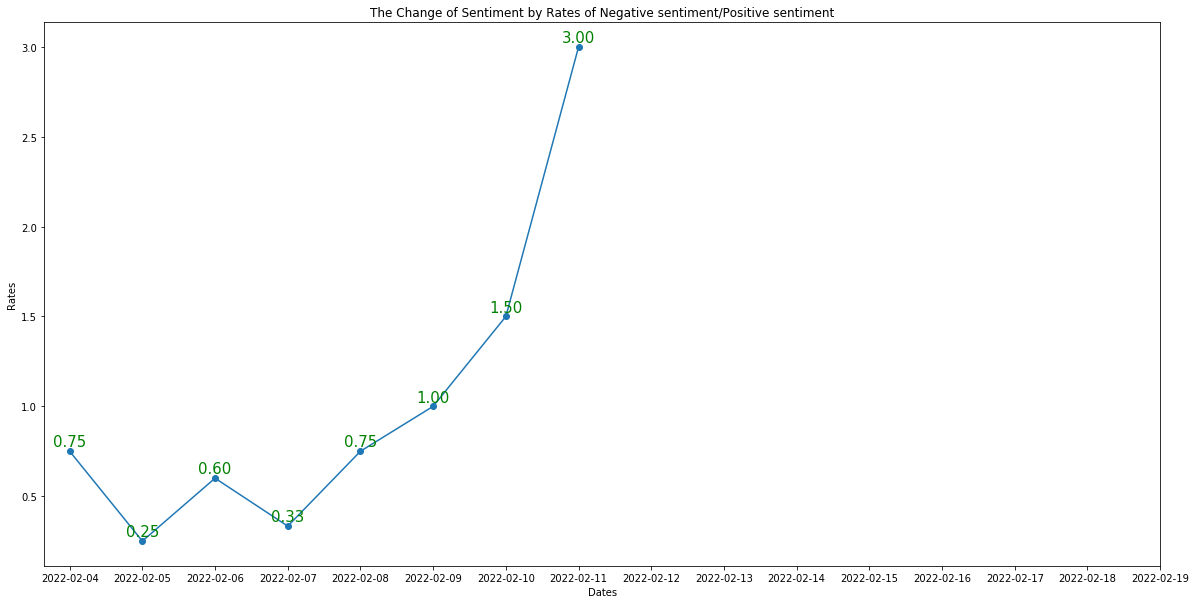

In [49]:
labels = []
for date in dates:
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    labels.append(cur_date)
    
plt.figure(figsize=(20,10))
plt.plot(rates, 'o-')
plt.xticks(range(len(labels)), labels)
plt.xlabel('Dates')
plt.ylabel('Rates')
plt.title("The Change of Sentiment by Rates of Negative sentiment/Positive sentiment")
x = dates
y = np.array(rates)
for _x, _y in zip(x, y):
    plt.text(_x-4, _y+0.01, '%.2f'%_y, ha='center', va='bottom', size=15, c='green')
plt.show()

# Named Entity Linking

In [27]:
# nlp = spacy.load("en_core_web_md")

# #add to pipeline
# nlp.add_pipe('entityLinker', last=True)

In [26]:
# for tweet_text in unique_tweets:
#     try:
#         doc = nlp(tweet_text)
#         print(tweet_text)
#         all_linked_entities = doc._.linkedEntities
#         for linked_entity in all_linked_entities:
#             print(linked_entity.get_url() + ' ' + linked_entity.pretty_string(True))
#         print()
#     except:
#         pass